# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


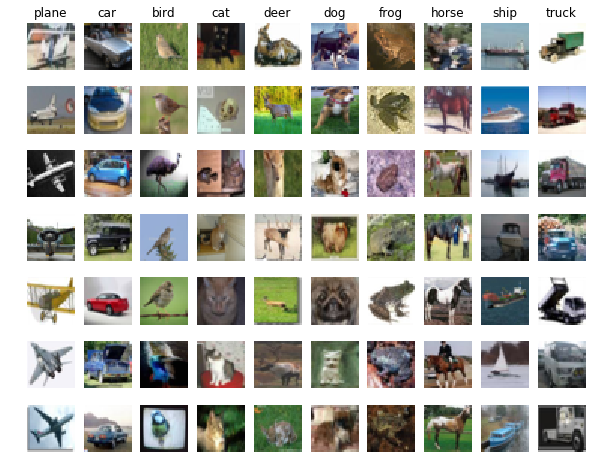

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):#对列表元素位置和每个类别进行循环，y表示元素位置（0,num_class），cls元素本身'plane'等
    idxs = np.flatnonzero(y_train == y)#找出标签中y类的位置
    idxs = np.random.choice(idxs, samples_per_class, replace=False)#从中选出我们所需的7个样本
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1 #在子图中所占位置的计算
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)#写上类名
plt.show()

In [13]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)


(5000, 3072) (500, 3072)
(5000,)


In [5]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [8]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


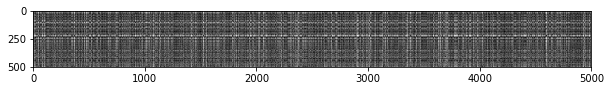

In [9]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ *1.The bright rows means this test image different with most train image. They may have very different backgourng,color or direction.
2.The bright columns means this train image different with most test image*



In [25]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

[ 420 3684 4224 ... 4375 2744 4601]
[420]
[4]
[2192 4848 2166 ... 4400 4688 1387]
[2192]
[9]
[4469  909 3904 ... 4921 3355 3837]
[4469]
[8]
[ 252 4453 4270 ... 4688 4921 1387]
[252]
[8]
[1881 3949 3797 ... 4271 2744 4601]
[1881]
[4]
[2654  347 1983 ...  790 4601 2744]
[2654]
[4]
[4033  831   22 ... 1342 2744 4601]
[4033]
[3]
[ 910 4055 1838 ... 4645 2744 4601]
[910]
[2]
[4808 1686 1283 ... 4813 4940 1387]
[4808]
[5]
[2096 4320  126 ... 2814 3035 4688]
[2096]
[8]
[ 303  456 1759 ... 1387 4940 3286]
[303]
[2]
[ 139  722 2905 ... 4921 3355 3837]
[139]
[8]
[2745 3540 4124 ... 4271 3205 4601]
[2745]
[5]
[ 825 4279  920 ... 1342 2744 1527]
[825]
[7]
[ 271 4066 2749 ... 4645 2744 4601]
[271]
[2]
[4183 4453 1832 ... 4273 1342 4564]
[4183]
[2]
[4153 1160 2550 ...  977 3737 4564]
[4153]
[5]
[  80 4864 4045 ... 4940 3286  735]
[80]
[3]
[3059 2192 2670 ... 4590 3355 3837]
[3059]
[1]
[1881 4139 4604 ... 4601 4418 1527]
[1881]
[4]
[2693 1440 1038 ...  735 4601  504]
[2693]
[2]
[1522 3382 3842 ... 18

[ 931 4969 2943 ... 2744  735 4601]
[931]
[6]
[1016 2836    3 ... 1342 4271 4601]
[1016]
[6]
[2894 1092  526 ... 4601 1527  504]
[2894]
[2]
[ 420 4224 1500 ... 4645 2744 4601]
[420]
[4]
[2266 2197   42 ... 4601 1527 4271]
[2266]
[5]
[3948  716 1500 ... 2744 4601 1527]
[3948]
[4]
[3077 2310 4090 ... 3286 4921 4564]
[3077]
[4]
[4200 3693 4801 ... 2065 4601  735]
[4200]
[1]
[2953 4134 2690 ... 4940 1387 4921]
[2953]
[9]
[3164 2213 4224 ...  735 2744  504]
[3164]
[2]
[4687 3245 3540 ... 4645 2744 4601]
[4687]
[4]
[2573 1746 2121 ...  504 2744 4601]
[2573]
[4]
[4583 3178 3663 ... 2744 1527 4601]
[4583]
[2]
[3873  420 4959 ... 4271 2744 4601]
[3873]
[6]
[1797 2797 2483 ...  504 3837 3355]
[1797]
[8]
[4056 2598 2478 ... 4656 1387 4940]
[4056]
[2]
[4208  982 4527 ...  504  735 4940]
[4208]
[6]
[2106 3408  933 ... 3286 4564 4940]
[2106]
[4]
[ 985 3506 1959 ... 4601 2744  504]
[985]
[6]
[2034 3918  557 ... 1387 3286 4940]
[2034]
[0]
[4808 4163 4905 ... 4273 4564 4331]
[4808]
[5]
[4577 1162 4066 

You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [27]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

[ 420 3684 4224 ... 4375 2744 4601]
[ 420 3684 4224 1161 4550]
[4 4 4 6 6]
4.0
[2192 4848 2166 ... 4400 4688 1387]
[2192 4848 2166 2172 3644]
[9 8 8 8 0]
8.0
[4469  909 3904 ... 4921 3355 3837]
[4469  909 3904 1726  139]
[8 8 8 5 8]
8.0
[ 252 4453 4270 ... 4688 4921 1387]
[ 252 4453 4270 2172 3039]
[8 2 0 8 8]
8.0
[1881 3949 3797 ... 4271 2744 4601]
[1881 3949 3797 4604 4262]
[4 5 4 2 4]
4.0
[2654  347 1983 ...  790 4601 2744]
[2654  347 1983 2372 4130]
[4 6 5 2 6]
6.0
[4033  831   22 ... 1342 2744 4601]
[4033  831   22 3525 1184]
[3 4 6 6 2]
6.0
[ 910 4055 1838 ... 4645 2744 4601]
[ 910 4055 1838 2746  347]
[2 4 2 7 6]
2.0
[4808 1686 1283 ... 4813 4940 1387]
[4808 1686 1283 4634 4306]
[5 8 2 2 2]
2.0
[2096 4320  126 ... 2814 3035 4688]
[2096 4320  126  193 1462]
[8 8 1 8 9]
8.0
[ 303  456 1759 ... 1387 4940 3286]
[ 303  456 1759 4808 1540]
[2 8 0 5 0]
0.0
[ 139  722 2905 ... 4921 3355 3837]
[ 139  722 2905 4291 4207]
[8 7 4 9 8]
8.0
[2745 3540 4124 ... 4271 3205 4601]
[2745 3540 4124 

[8 8 8 8 5]
8.0
[4985 4113 1139 ... 4400 1387 4921]
[4985 4113 1139 1665 3438]
[4 2 2 8 0]
2.0
[4426 1136 2112 ... 1342 2744 4601]
[4426 1136 2112 1596 3843]
[2 5 6 6 3]
6.0
[4463 3194 1600 ... 1342 4418  504]
[4463 3194 1600 4755  986]
[5 3 5 2 2]
2.0
[ 157 1160  931 ... 4331 1342 4564]
[ 157 1160  931  197 1600]
[5 3 6 3 5]
3.0
[4283 1036 4166 ... 2744 1342 4375]
[4283 1036 4166 4579 3152]
[8 8 3 5 5]
5.0
[ 600 3246 2868 ... 3035 1387 4921]
[ 600 3246 2868 3617 1593]
[0 0 2 3 0]
0.0
[ 101  338 2472 ... 4375 2744  504]
[ 101  338 2472 4164 1120]
[3 7 7 9 3]
3.0
[ 710 2595 2782 ... 1527 4645 4601]
[ 710 2595 2782 1798 2350]
[6 2 3 2 0]
2.0
[ 341  974 2193 ... 1387 3467 4940]
[ 341  974 2193  987 1972]
[0 0 2 8 9]
0.0
[3670 4773 1491 ...  221  735 3199]
[3670 4773 1491 2943 4801]
[8 4 4 4 4]
4.0
[1324 1881 2116 ... 2744 1342 4601]
[1324 1881 2116 2130 2694]
[4 4 4 3 6]
4.0
[2441  957 2034 ... 4813 1387 4940]
[2441  957 2034 1432 2617]
[8 2 0 0 0]
0.0
[4834 2483  139 ... 4921 1387 3355]


[4540 4096 1439 ... 4921 4940 1387]
[4540 4096 1439 3039 4617]
[0 0 8 8 8]
8.0
[  69 3939 2603 ... 4601 2263 2814]
[  69 3939 2603 3845 2875]
[8 7 8 2 2]
2.0
[4594 1640 4643 ... 1766 1387 4940]
[4594 1640 4643 4053 3677]
[8 4 9 4 9]
4.0
[1141 3043  420 ... 4601  504 1342]
[1141 3043  420 1542 4868]
[8 3 4 2 0]
0.0
[3847  420 2372 ... 4271 2744 4601]
[3847  420 2372 3684   58]
[2 4 2 4 4]
4.0
[1838  347 2372 ... 4645 2744 4601]
[1838  347 2372 2730 2812]
[2 6 2 5 2]
2.0
[2894 1162 3065 ... 4601 1342  504]
[2894 1162 3065 4925 4286]
[2 8 8 0 4]
8.0
[1161 1535 1271 ...  816 4601 2744]
[1161 1535 1271 4193 3960]
[6 4 3 4 5]
4.0
[2573 4224 1832 ... 2744 4601  504]
[2573 4224 1832 1728 2875]
[4 4 4 4 2]
4.0
[3166 1777  243 ... 4645 4601  735]
[3166 1777  243 1917 3383]
[4 2 6 6 4]
4.0
[1178 4941  757 ... 3467 3286 4940]
[1178 4941  757 3918 3184]
[0 0 0 0 0]
0.0
[2229 3579  557 ... 4940 1387 3286]
[2229 3579  557 1249 4723]
[8 8 0 0 8]
8.0
[ 420 1838 4550 ... 4271 2744 4601]
[ 420 1838 4550 

[2 4 3 2 2]
2.0
[3493 2707 3176 ... 4921 4400 1387]
[3493 2707 3176 4466 1686]
[8 0 4 8 8]
8.0
[3873 1314 3173 ... 4418 4601 4271]
[3873 1314 3173 3949 2567]
[6 8 5 5 2]
5.0
[4770  299  345 ... 3205 1527 4601]
[4770  299  345 2666   26]
[6 4 4 8 3]
4.0
[1092 1284 4887 ... 4601  504 2744]
[1092 1284 4887   69 3874]
[8 4 3 8 8]
8.0
[2943 1875 4969 ... 4500 4601  735]
[2943 1875 4969  552 1491]
[4 5 4 6 4]
4.0
[ 882 1284 4298 ... 1527 2744  504]
[ 882 1284 4298 1711 3246]
[3 4 8 0 0]
0.0
[2842 3245 2116 ... 2744 4645 4601]
[2842 3245 2116 1268 3193]
[4 2 4 4 2]
4.0
[1530  334 1596 ... 4645 2744 4601]
[1530  334 1596 1436 1367]
[2 3 6 6 6]
6.0
[4661 4349  804 ...  504 2744 4601]
[4661 4349  804 4144  622]
[1 3 2 6 4]
1.0
[ 592 2575 1832 ... 1387 3286 4940]
[ 592 2575 1832 4808 3627]
[8 2 4 5 7]
2.0
[  10  910 4007 ... 4645 2744 4601]
[  10  910 4007 2812 2018]
[4 2 3 2 8]
2.0
[1557 4492 4643 ... 1363 1527 3837]
[1557 4492 4643 1472 4594]
[4 1 9 9 8]
9.0
[1711 1141  139 ...  504 3355 3837]


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$


In [ ]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

In [ ]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$

